**Introduction:**

We saw in `backtest.ipynb`, our initial backtest efforts, that the statistical arbitrage strategy is prone to large drawdowns during times of volatility.

This makes sense - relationships between stocks and their betas break down during large rallies and crashes. The inherent bet for statistical arbitrage is that there exists momentum reversal, but if adverse conditions occuring during a position hold, then of course significant losses (and occasionally, gains) can occur.

But we would rather have a nice smooth equity curve. Can we detect regimes in the market using the S & P 500 index? We consider multiple different approaches to regime detection supported by academic literature and real life models.

**Motivation:**

The motivation for this research came from an academic paper seen [here](https://www.mdpi.com/1911-8074/13/12/311). It is titled 'Regime-Switching Factor Investing with Hidden Markov Models' by Matthew Wang, Yi-Hong Lin and Ilya Mikhelson. It considers a sort of ensemble of factor models that each have different return profiles for different regimes, and then utilising regime detection to switch investment profiles throughout the investment period.

### Gaussian Mixture Models

Reference: [Two Sigma article on GMMS for regime detection](https://www.twosigma.com/articles/a-machine-learning-approach-to-regime-modeling/)

In the above, Two Sigma discuss how their investment product `Factor Lens` utilises GMMs to detect regimes. In my research, I consider `3` types of market conditions (taking inspiration from the paper seen in motivation). These are `bear`, `bull` and `neutral`.

We pass in two predictor variables - returns and rolling 15 day volatility.

In [24]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv()

db_url = os.getenv('DB_URL')

psql = create_engine(db_url)

In [25]:
spy = pd.read_sql(
    """
    select
        *
    from
        adjusted_historical
    where
        ticker = 'SPY'
    """,
    psql
)
spy['close_to_close'] = np.log(spy['adj_close'] / spy['adj_close'].shift())

In [26]:
spy['volatility'] = spy['close_to_close'].rolling(window = 15).std()
spy['rolling_volatility'] = spy['volatility'].ewm(halflife=15).mean()

#### Sense-checking data and return profile

Text(0.5, 0, 'Date')

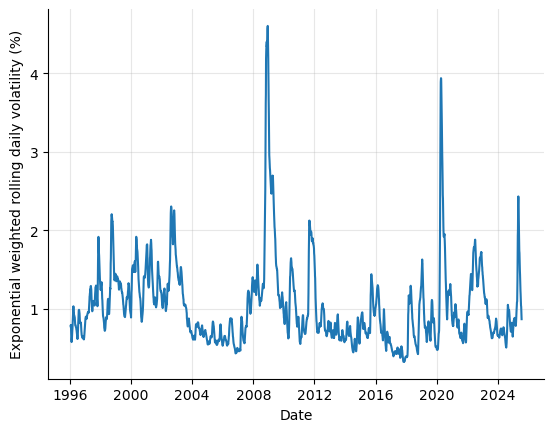

In [27]:
plt.plot(spy['date'], spy['rolling_volatility'] * 100)
plt.grid(alpha=0.3)
sns.despine()
plt.ylabel('Exponential weighted rolling daily volatility (%)')
plt.xlabel('Date')

Text(0.5, 0, 'Close to close returns (%)')

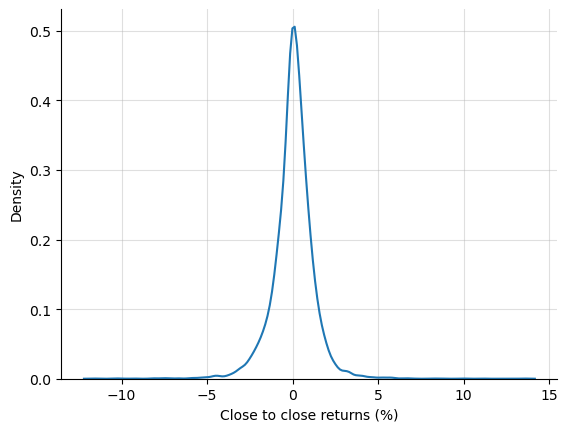

In [28]:
sns.kdeplot(spy['close_to_close'] * 100)
sns.despine()
plt.grid(alpha=0.4)
plt.xlabel('Close to close returns (%)')

#### Fitting the GMM model

In [120]:
# now fitting the gaussian mixture model
from sklearn.mixture import GaussianMixture

spy['smoothed_ctc'] = spy['close_to_close'].rolling(window=5).mean()
spy['smoothed_vol'] = spy['volatility'].rolling(window=5).mean()
spy = spy.dropna()

gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=100000, n_init=30, init_params='kmeans')
spy['regime'] = gmm.fit_predict(spy[['close_to_close', 'volatility']])

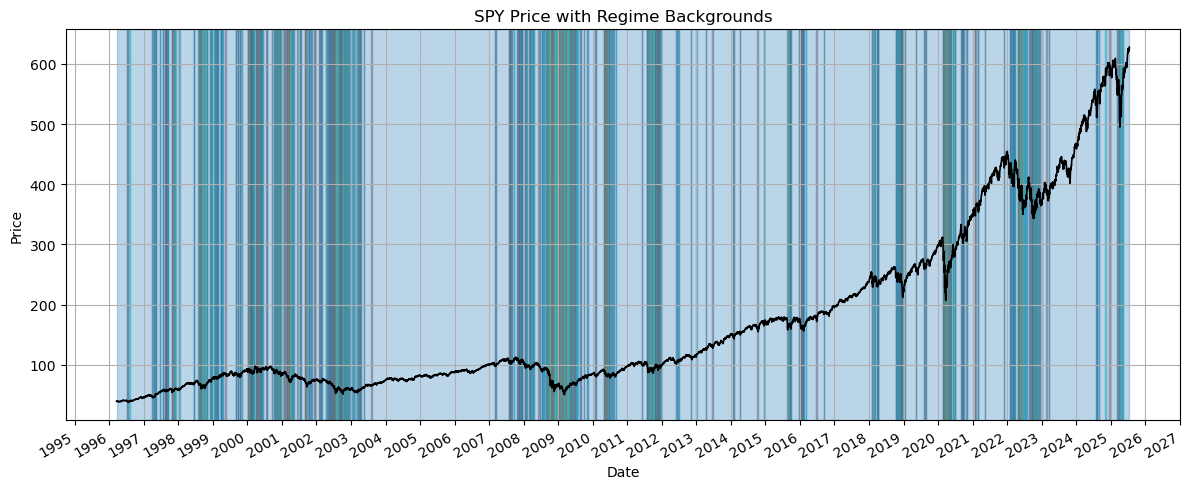

In [121]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Ensure 'date' is datetime
spy['date'] = pd.to_datetime(spy['date'])
spy = spy.sort_values('date')

# Assign colors to regimes
unique_regimes = spy['regime'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_regimes)))
regime_color_map = dict(zip(unique_regimes, colors))

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

# Draw background blocks
start = spy['date'].iloc[0]
prev_regime = spy['regime'].iloc[0]

for i in range(1, len(spy)):
    curr_regime = spy['regime'].iloc[i]
    if curr_regime != prev_regime:
        ax.axvspan(start, spy['date'].iloc[i], color=regime_color_map[prev_regime], alpha=0.3)
        start = spy['date'].iloc[i]
        prev_regime = curr_regime

# Final span
ax.axvspan(start, spy['date'].iloc[-1], color=regime_color_map[prev_regime], alpha=0.3)

# Line plot using 'date' as x-axis
ax.plot(spy['date'], spy['adj_close'], color='black', linewidth=1.2)

# Format date axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('SPY Price with Regime Backgrounds')
ax.grid(True)
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


We can clearly begin to see some patterns in the above chart - the lightest blue seems to indicate regions of significant distress. Let us consider metrics for each regime and make a more informed decision on what we should call these regimes.

In [122]:
regime_statistics = spy.groupby('regime')[['close_to_close', 'volatility', 'rolling_volatility']].mean().reset_index().rename(
    columns = {
        'regime': 'Regime',
        'close_to_close': 'Close to Close Returns',
        'volatility': 'Volatility',
        'rolling_volatility': 'Rolling Volatility'
    }
)

regime_statistics['Close to Close Returns'] = round(regime_statistics['Close to Close Returns'], 4)
regime_statistics['Volatility'] = round(regime_statistics['Volatility'], 4)
regime_statistics['Rolling Volatility'] = round(regime_statistics['Rolling Volatility'], 4)
regime_statistics

,Regime,Close to Close Returns,Volatility,Rolling Volatility
0,0,0.0009,0.0084,0.0090
1,1,-0.0224,0.0200,0.0169
2,2,0.0184,0.0216,0.0185


We can clearly see three regimes of 'bull', 'bear' and 'neutral' by their return and volatility profiles.

### Considering statistical arbitrage performance during regimes

We now consider how the arbitrage strategy performs during these regimes of 'bull', 'bear' and 'neutral'. Note this is an `in-sample` analysis; and of course, has contamination as the regime is trained on the entire history.

In [123]:
performance = pd.read_sql(
    """
    select * from positions
    """,
    psql
)
performance['date'] = pd.to_datetime(performance['date'])
spy['date'] = pd.to_datetime(spy['date'])

In [124]:
performance

,date,vw_long_return,vw_short_return,portfolio_return,portfolio_return_winsorized,total_positions
0,1999-09-13,0.004274,0.001813,0.006087,0.006087,176
1,1999-09-14,0.008592,-0.005612,0.002980,0.002980,180
2,1999-09-15,-0.011395,0.030302,0.018907,0.018907,177
3,1999-09-16,0.001407,0.008749,0.010155,0.010155,180
4,1999-09-17,-0.014879,-0.001938,-0.016817,-0.016817,180
...,...,...,...,...,...,...
6496,2025-07-11,-0.002053,-0.000940,-0.002994,-0.002994,418
6497,2025-07-14,-0.005950,-0.005651,-0.011601,-0.011601,416
6498,2025-07-15,-0.005032,-0.005476,-0.010507,-0.010507,425
6499,2025-07-16,-0.006065,0.003980,-0.002085,-0.002085,419


In [125]:
regime_performance = spy.merge(
    performance,
    how='left',
    on='date'
).dropna()

performance_in_regimes = (
    regime_performance
        .groupby('regime')
        .agg({
            'vw_long_return': ['mean', 'std', 'min', 'count'],
            'vw_short_return': ['mean', 'std', 'min'],
            'portfolio_return': ['mean', 'std'],
            'close_to_close': 'mean',
            'rolling_volatility': 'mean'
        })
)

In [127]:
performance_in_regimes.reset_index()

regime vw_long_return                           vw_short_return            \
                   mean       std       min count            mean       std   
0      0       0.000578  0.015889 -0.660991  5444       -0.000183  0.011222   
1      1      -0.002877  0.015344 -0.104816   539        0.005235  0.016494   
2      2       0.002258  0.013953 -0.059227   518       -0.000756  0.028573   

            portfolio_return           close_to_close rolling_volatility  
        min             mean       std           mean               mean  
0 -0.219560         0.000395  0.019639       0.000845           0.008803  
1 -0.077227         0.002358  0.022273      -0.022407           0.017208  
2 -0.107755         0.001502  0.032335       0.018285           0.018797

We can't necessarily see that statistical arbitrage performs worse or better with statistical significance in any of the regimes. We do see large drawdowns (almost ~60%!), and in the following sections, we'll consider whether these would be avoidable.

### Event analysis: the GFC crash

In [129]:
gfc_crash = regime_performance[
    (regime_performance['date'] >= '2007-06-01') &
    (regime_performance['date'] <= '2009-06-01')
]

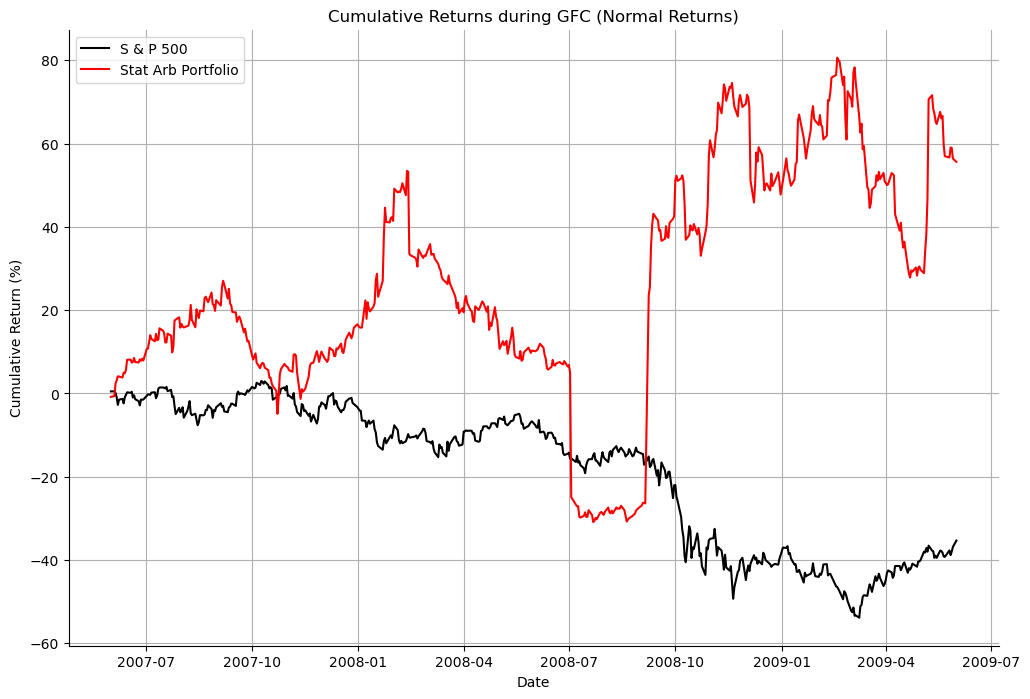

In [142]:
plt.figure(figsize=(12, 8))

cumulative_price_return = np.exp(gfc_crash['close_to_close'].cumsum()) - 1
cumulative_portfolio_return = np.exp(gfc_crash['portfolio_return'].cumsum()) - 1

plt.plot(
    gfc_crash['date'], 
    cumulative_price_return * 100, 
    label='S & P 500', 
    color='black')
plt.plot(
    gfc_crash['date'], 
    cumulative_portfolio_return * 100, 
    label='Stat Arb Portfolio', 
    color='red')

plt.title('Cumulative Returns during GFC (Normal Returns)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
sns.despine()
plt.show()

We see a pretty drastic drop on the 3rd of July, 2008. What happened?

In [148]:
gfc_crash['sp500_returns'] = np.exp(gfc_crash['close_to_close'].cumsum()) - 1
gfc_crash['statarb_returns'] = np.exp(gfc_crash['portfolio_return'].cumsum()) - 1
gfc_crash['date'] = gfc_crash['date'].dt.strftime('%Y-%m-%d')

/var/folders/qq/9n_h2x6x0pl9pvyr0gpk4m_r0000gn/T/ipykernel_9029/1137386217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gfc_crash['sp500_returns'] = np.exp(gfc_crash['close_to_close'].cumsum()) - 1
/var/folders/qq/9n_h2x6x0pl9pvyr0gpk4m_r0000gn/T/ipykernel_9029/1137386217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gfc_crash['statarb_returns'] = np.exp(gfc_crash['portfolio_return'].cumsum()) - 1
/var/folders/qq/9n_h2x6x0pl9pvyr0gpk4m_r0000gn/T/ipykernel_9029/1137386217.py:3: SettingWithCopyWa

In [149]:
gfc_crash.to_excel('../paper/sheet/gfc_crash.xlsx')